<div>
    <center>
        <h1>
            <font color="#902e59">CQF June 2023 Intake: Final Project</font>
        </h1>
    </center>
    <center>
        <h3>Deep Learning for Asset Prediction</h3>
    </center>
    <center>
        <h5>Will Colgate, Singapore, January 2024</h5>
    </center>
</div>


### Problem Statement
The objective is to produce a model that can predict positive moves using Long Short-Term Memory (LSTM) networks.

I have chosen Ethereum as the ticker to analyse (technically a pair with USD). Crypto markets are notoriously volatile and it seems like a decent challenge to try and tease some insight out of the mess.

For this purpose, I will aim to predict the positive trend over 6 hours only. This will be a binary classification problem with accuracy as the main metric used to measure the effectiveness of the model. The baseline to test the effectiveness fo the model against would be a random guess (i.e. a 50% chance of being correct).

### Data Collection

##### Raw Data

Using `download.py`, I have downloaded two years worth of hourly ticker data. This script wraps a simple function that pulls data from `yfinance`. The data is saved locally in "ETH-USD_2y_1h.csv" for convenience.

`yfinance` has a restriction on the amount of hourly data that can be downloaded and restricts this to 730 days of data (i.e. 2 years). Given crypto markets never close, this amounts to 17k+ data points. As a general rule of thumb, 5 years of daily data would be required to predict daily returns. On a normal security, this would only be approximately 1,300 data points. Therefore, 2 years of hourly data should be more than sufficient for this problem. In fact, the amount of data may need to be reduced due to hardware constraints.

In [180]:
# Imports
from src.config import *
# Base
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [181]:
# Collect the data into a dataframe
csv = 'data/raw/ETH-USD_2y_1h.csv'
df = pd.read_csv(csv, index_col='Datetime', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-12-10 11:00:00+00:00,4094.138428,4168.385254,4088.458496,4159.988770,0,0.0,0.0
2021-12-10 12:00:00+00:00,4158.929199,4194.666504,4156.186523,4171.749512,371617792,0.0,0.0
2021-12-10 13:00:00+00:00,4171.667969,4227.111816,4141.002441,4204.396484,1012555776,0.0,0.0
2021-12-10 14:00:00+00:00,4205.823242,4212.586914,4028.301270,4028.301270,0,0.0,0.0
2021-12-10 15:00:00+00:00,4037.234131,4086.067383,3998.373779,4015.867920,717191168,0.0,0.0


### Exploratory Data Analysis


In [182]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,17485.0,1.940922e+03,6.728440e+02,902.475952,1559.277222,1784.905029,2.040799e+03,4.205823e+03
High,17485.0,1.947399e+03,6.756417e+02,921.278198,1564.480469,1790.515625,2.048271e+03,4.227112e+03
Low,17485.0,1.934211e+03,6.697479e+02,896.300049,1553.950684,1778.494019,2.032429e+03,4.156187e+03
Close,17485.0,1.940835e+03,6.726981e+02,896.575623,1559.341064,1784.716431,2.040379e+03,4.204396e+03
Volume,17485.0,1.633657e+08,4.769001e+09,0.000000,0.000000,0.000000,1.216338e+08,6.273375e+11
Dividends,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
Stock Splits,17485.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00


The above looks fairly standard for data from `yfinance`. Immediately we can drop Dividends and Stock Splits given this is a crypto token and the entries are all zero in the data.

There appear to be large range of volumes (including nil volumes). The spike in volumes in May 2022 coincided with collapsed of Terra. Given the large range of values and significant outliers, this feature could be candidate for scaling with statistics that are robust to outliers (such as `scikit-learn`'s `RobustScaler`).

In [183]:
# Looking at the zero volume entries
df['Volume'][df['Volume'] == 0]

Datetime
2021-12-10 11:00:00+00:00    0
2021-12-10 14:00:00+00:00    0
2021-12-10 18:00:00+00:00    0
2021-12-10 20:00:00+00:00    0
2021-12-10 21:00:00+00:00    0
                            ..
2023-12-10 05:00:00+00:00    0
2023-12-10 06:00:00+00:00    0
2023-12-10 07:00:00+00:00    0
2023-12-10 08:00:00+00:00    0
2023-12-10 09:00:00+00:00    0
Name: Volume, Length: 9100, dtype: int64

The above suggests the volume data is unreliable given it is unlikely there were 375 days (i.e. 9,100 hours) where not a single transactions was registered. 

Therefore, I hunted for an alternative datasource and found [www.cryptodatadownload.com]() which has hourly data for Gemini, a fairly reputable exchange. I can;t speak for the source of the data and it's accuracy but the Gemini API itself only serves data for the past two months, which is unlikely to be enough. For the sake of this experiment, I will use the csv data downloaded from the website. In production, more reliable data straight from the exchange should be procured before making any investment decisions with real money.

In [184]:
df = pd.read_csv('data/raw/Gemini_ETHUSD_1h.csv', parse_dates=True, skiprows=[0], index_col='date')
# Drop unix and symbol columns
df.drop(['unix', 'symbol'], axis=1, inplace=True)
# Sort date ascending
df.sort_index(inplace=True)
df.head()

,open,high,low,close,Volume ETH,Volume USD
date,,,,,,
2016-05-09 13:00:00,0.00,12.00,0.00,9.55,432.562115,4130.968200
2016-05-09 14:00:00,9.55,10.00,9.55,10.00,235.774075,2357.740748
2016-05-09 15:00:00,10.00,10.00,9.99,9.99,10.973567,109.625935
2016-05-09 16:00:00,9.99,9.99,9.79,9.83,62.379450,613.189994
2016-05-09 17:00:00,9.83,9.83,9.48,9.49,329.553213,3127.459991


In [185]:
# Load sentiment data
df_sentiment = pd.read_csv('data/raw/crypto_greed_fear_index.csv', parse_dates=True, index_col='timestamp')
df_sentiment.drop(['time_until_update', 'timestamp.1'], axis=1, inplace=True)
df_sentiment.head()

,value,value_classification
timestamp,,
2023-12-20,74,Greed
2023-12-19,73,Greed
2023-12-18,65,Greed
2023-12-17,73,Greed
2023-12-16,67,Greed


In [186]:
# Join the sentiment data to price data
df = df.join(df_sentiment)
df['value'].ffill(inplace=True)
df['value_classification'].ffill(inplace=True)
df.tail()

,open,high,low,close,Volume ETH,Volume USD,value,value_classification
date,,,,,,,,
2023-12-12 19:00:00,2187.81,2188.03,2172.59,2176.29,103.032324,224228.216398,67.0,Greed
2023-12-12 20:00:00,2176.29,2187.75,2170.26,2186.10,262.450524,573743.090516,67.0,Greed
2023-12-12 21:00:00,2186.10,2190.25,2166.69,2172.23,173.656678,377222.245652,67.0,Greed
2023-12-12 22:00:00,2172.23,2190.22,2170.76,2187.34,93.143372,203736.223310,67.0,Greed
2023-12-12 23:00:00,2187.34,2205.30,2187.34,2202.01,193.550211,426199.500124,67.0,Greed


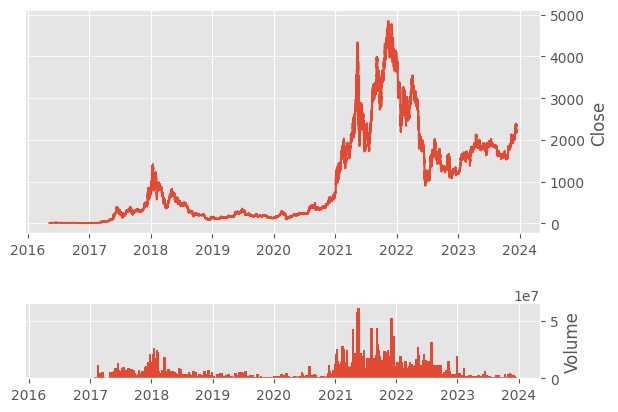

In [187]:
# Plotting closing price and volume
plot_price_vol(df, 'close', 'Volume USD')

In [188]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,66560.0,1004.789205,1.099324e+03,0.00,176.150000,410.160000,1705.780000,4.848520e+03
high,66560.0,1010.772388,1.105774e+03,6.15,177.000000,412.885000,1714.782500,4.870510e+03
low,66560.0,998.351651,1.092364e+03,0.00,175.017500,408.000000,1696.452500,4.836100e+03
close,66560.0,1004.822234,1.099327e+03,6.10,176.157500,410.240000,1705.840000,4.848520e+03
Volume ETH,66560.0,1137.822180,5.130146e+03,0.00,101.002439,363.020333,1066.231033,9.031027e+05
Volume USD,66560.0,853183.844922,1.938352e+06,0.00,35475.951774,192636.120280,851802.583223,6.121758e+07
value,51381.0,43.901715,2.140962e+01,5.00,26.000000,41.000000,59.000000,9.500000e+01


The new data looks much more reasonable and seems to include more data points for volatility. There is also much more data availably, whihc should hopefully help with training the model. Again, I may need to remove some of this data due to hardware limitations. I will use this going forwards.

Looking at the initial data, the metioric rise of cryto in 2020/2021 and ths subsequent crash due to Terra Luna depegging and FTX collapse are obviously present. It's encouraging (as somebody that owns some ETH) that the price has started to climb again.

There are definite phases in the price trend, going from relative obscurity to meteoric rise followed by the well known crash. For this and performance reasons, it seems reasonable to take a much smaller subset of the data. Given a general rule of thumb is 5 years of data for a model to predict daily returns, 1300 (i.e. 260 x 5) datapoints is all that is required. However, given we have so much data and there has been a lot of variation i the market in the past 2 years, I have taken the prior two years data.

In [189]:
df = df['2021-12-13':]
# Add the return
df['RET'] = np.log(df['close'] / df['close'].shift(1))
df.dropna(inplace=True, axis=0)
# Add hours, days, months to investigate seasonality
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

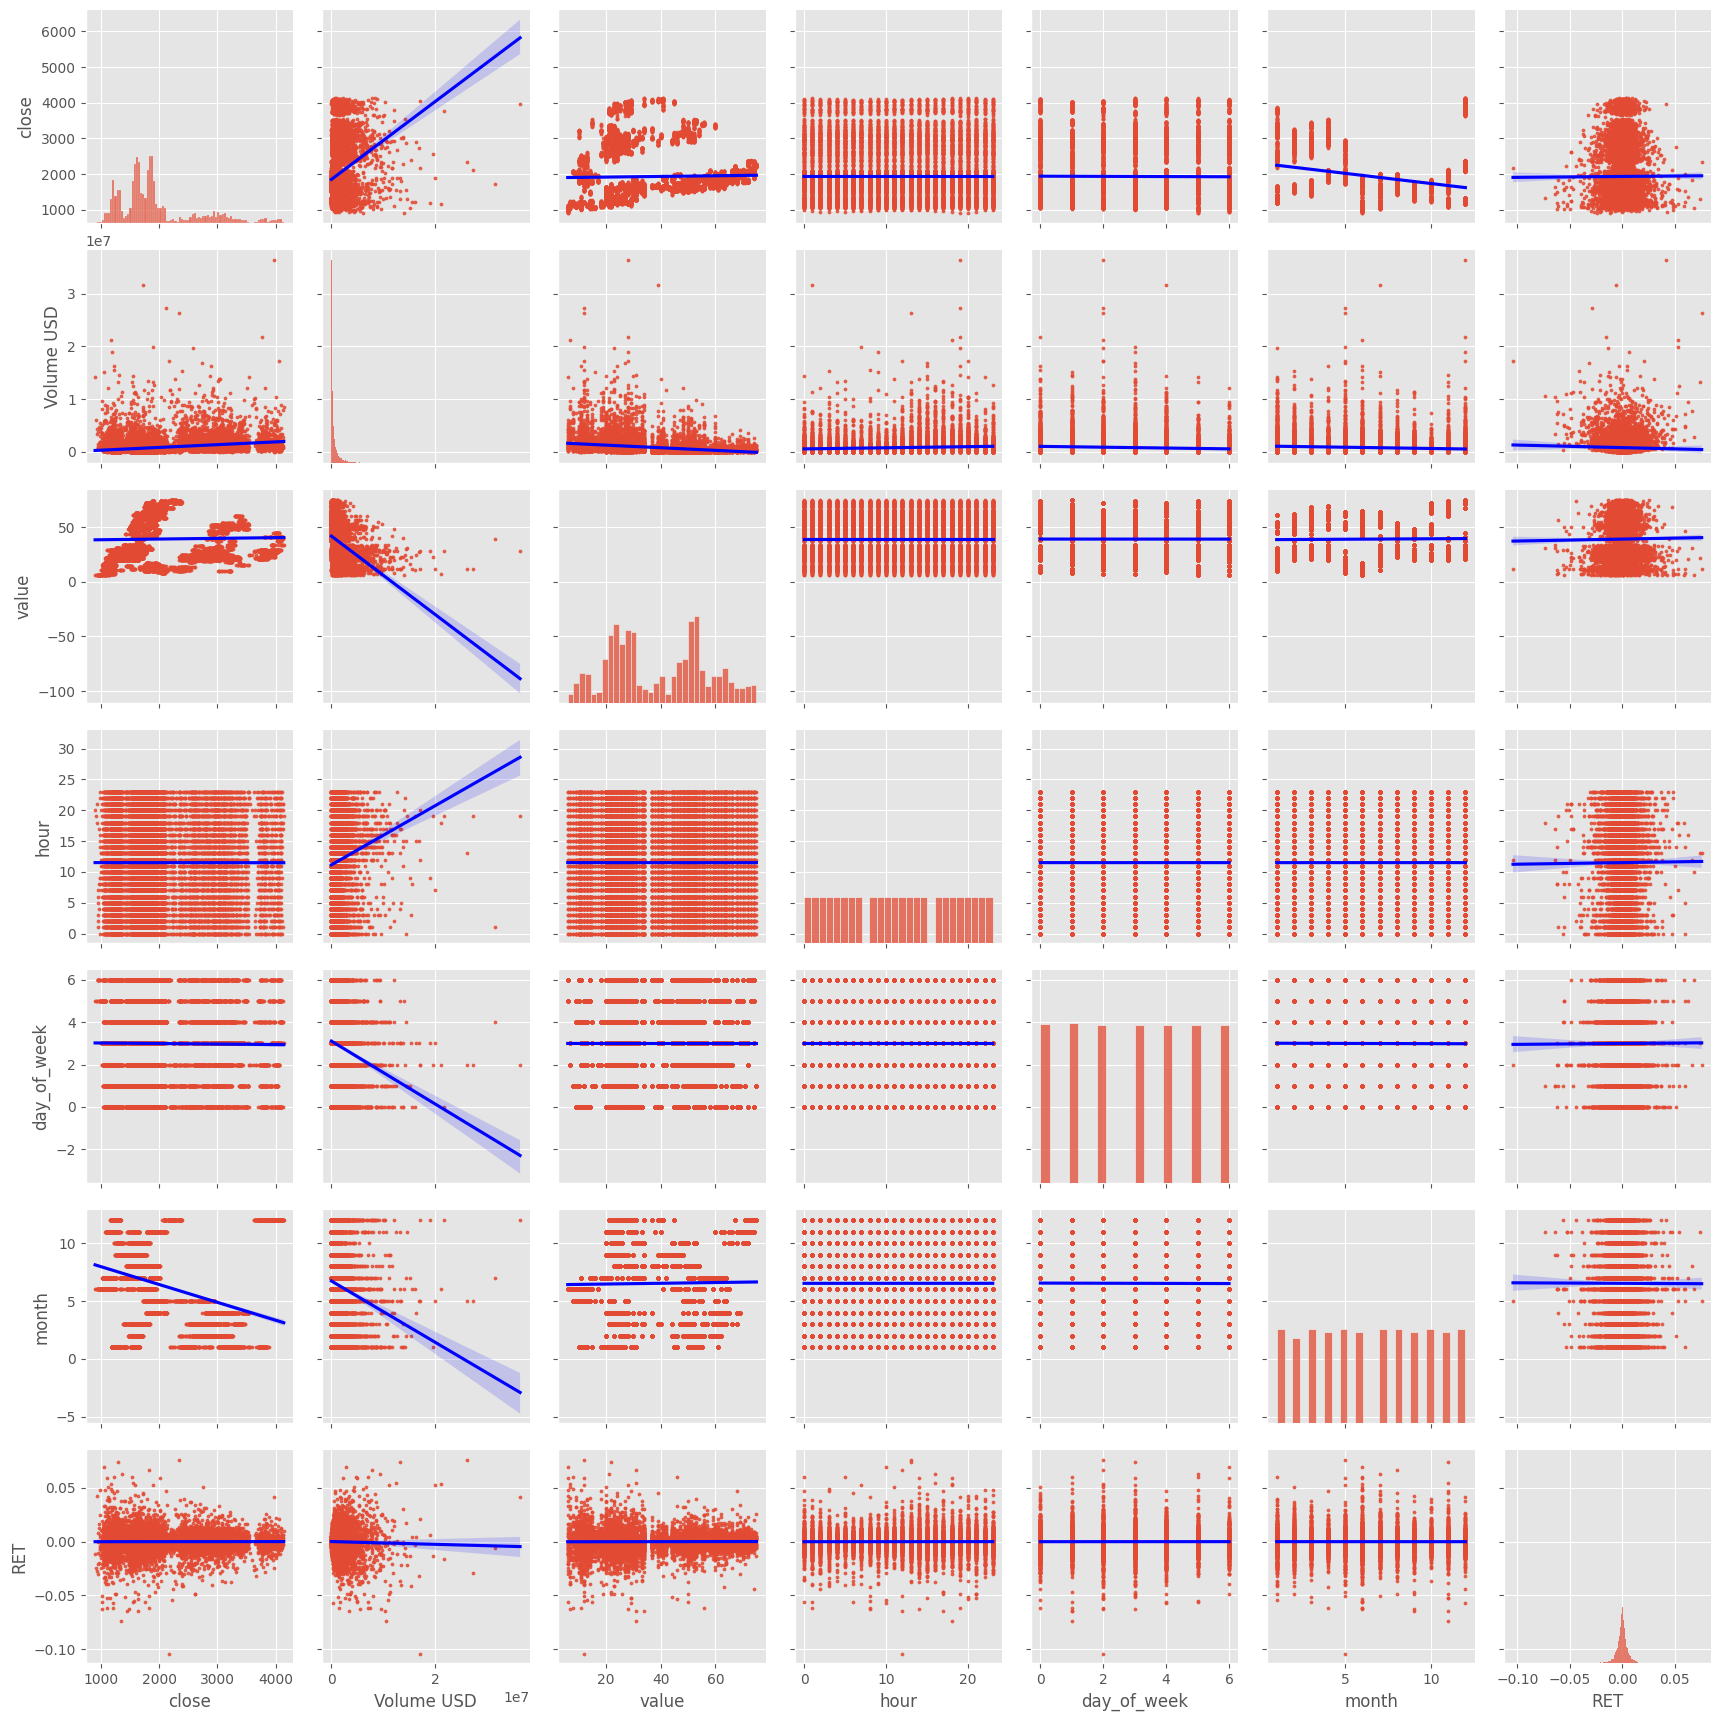

In [196]:
# Create a pairplot to examine all the data 
sns.pairplot(df[['close', 'Volume USD', 'value', 'hour', 'day_of_week', 'month', 'RET']], kind='reg', plot_kws={'line_kws':{'color':'blue'}, 'scatter_kws':{'s':3}})
plt.show()

A few observations from the pairplot:

- The return does not seem to have any seasonality to it over the past 2 years, with the trend line indicating corrolation close to (if not exactly) zero.
- The fear and greed index, although having minimal correlation, appear to exhibit heteroskedasticity, indicating that as the greed index rises, the volatility in return tends to fall. The greed index could be a good indiactior of volatility in the market.
- There are a few outliers for volume, potentially indicaing it is a good candidate for a robust scaler.
- Volume tends to drop as the index indicates more greediness.
- The closing price tends to fall throughout the year. However, there are only 2 of each month in the dataset so this is unlikely to be indicitive. Potentially need to drop this point.
- As expected, returns exhibit stochastic characteristics and look relative normal in their distribution. 

### Data Cleaning

Just looking at the data, it seems fairly complete but I will do some basic checks to confirm this is the case.

In [191]:
# Checking for null values
df.isnull().sum()

open                    0
high                    0
low                     0
close                   0
Volume ETH              0
Volume USD              0
value                   0
value_classification    0
RET                     0
hour                    0
day_of_week             0
month                   0
dtype: int64

As expected, the data is clean and we can start with feature engineering. 

### Data Transformation
##### Feature Creation

In `feature.py`, I have created a script that calculates various technical indicators. These features are well documented online but I have included a summary of 

##### Feature Creation

##### Feature Creation

##### Feature Creation


### Deep Learning Model


### Model Validation


### Backtesting

